In [4]:
# %load demo.py
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import coco
import utils
import model as modellib
# import visualize
import torch
import cv2
import json

In [5]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# Download this file and place in the root of your
# project (See README file for details)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.pth")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # GPU_COUNT = 0 for CPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Create model object.
model = modellib.MaskRCNN(model_dir=MODEL_DIR, config=config)
if config.GPU_COUNT:
    model = model.cuda()

# Load weights trained on MS-COCO
model.load_state_dict(torch.load(COCO_MODEL_PATH))

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image])

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
#                             class_names, r['scores'])
# plt.show()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGENET_MODEL_PATH            /home/paperspace/zen/scene++/scene++_server/resnet50_imagenet.pth
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81

/home/paperspace/zen/scene++/scene++_server/model.py:1474: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [6]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
if "DISPLAY" not in os.environ:
    plt.switch_backend('agg')
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interporlation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
    return masked_image.astype(np.uint8)

def draw_rois(image, rois, refined_rois, mask, class_ids, class_names, limit=10):
    """
    anchors: [n, (y1, x1, y2, x2)] list of anchors in image coordinates.
    proposals: [n, 4] the same anchors but refined to fit objects better.
    """
    masked_image = image.copy()

    # Pick random anchors in case there are too many.
    ids = np.arange(rois.shape[0], dtype=np.int32)
    ids = np.random.choice(
        ids, limit, replace=False) if ids.shape[0] > limit else ids

    fig, ax = plt.subplots(1, figsize=(12, 12))
    if rois.shape[0] > limit:
        plt.title("Showing {} random ROIs out of {}".format(
            len(ids), rois.shape[0]))
    else:
        plt.title("{} ROIs".format(len(ids)))

    # Show area outside image boundaries.
    ax.set_ylim(image.shape[0] + 20, -20)
    ax.set_xlim(-50, image.shape[1] + 20)
    ax.axis('off')

    for i, id in enumerate(ids):
        color = np.random.rand(3)
        class_id = class_ids[id]
        # ROI
        y1, x1, y2, x2 = rois[id]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              edgecolor=color if class_id else "gray",
                              facecolor='none', linestyle="dashed")
        ax.add_patch(p)
        # Refined ROI
        if class_id:
            ry1, rx1, ry2, rx2 = refined_rois[id]
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal for easy visualization
            ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

            # Label
            label = class_names[class_id]
            ax.text(rx1, ry1 + 8, "{}".format(label),
                    color='w', size=11, backgroundcolor="none")

            # Mask
            m = utils.unmold_mask(mask[id], rois[id]
                                  [:4].astype(np.int32), image.shape)
            masked_image = apply_mask(masked_image, m, color)

    ax.imshow(masked_image)

    # Print stats
    print("Positive ROIs: ", class_ids[class_ids > 0].shape[0])
    print("Negative ROIs: ", class_ids[class_ids == 0].shape[0])
    print("Positive Ratio: {:.2f}".format(
        class_ids[class_ids > 0].shape[0] / class_ids.shape[0]))


# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")


def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,
                  overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictins and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)),
               ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),
               [class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh
                 else "black" if overlaps[i, j] > 0
                 else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),
                 horizontalalignment="center", verticalalignment="center",
                 fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None,
               masks=None, captions=None, visibilities=None,
               title="", ax=None):
    """Draw bounding boxes and segmentation masks with differnt
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominant each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            x = random.randint(x1, (x1 + x2) // 2)
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
#     ax.imshow(masked_image.astype(np.uint8))
    return masked_image.astype(np.uint8)

def plot_loss(loss, val_loss, save=True, log_dir=None):
    loss = np.array(loss)
    val_loss = np.array(val_loss)

    plt.figure("loss")
    plt.gcf().clear()
    plt.plot(loss[:, 0], label='train')
    plt.plot(val_loss[:, 0], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    if save:
        save_path = os.path.join(log_dir, "loss.png")
        plt.savefig(save_path)
    else:
        plt.show(block=False)
        plt.pause(0.1)

    plt.figure("rpn_class_loss")
    plt.gcf().clear()
    plt.plot(loss[:, 1], label='train')
    plt.plot(val_loss[:, 1], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    if save:
        save_path = os.path.join(log_dir, "rpn_class_loss.png")
        plt.savefig(save_path)
    else:
        plt.show(block=False)
        plt.pause(0.1)

    plt.figure("rpn_bbox_loss")
    plt.gcf().clear()
    plt.plot(loss[:, 2], label='train')
    plt.plot(val_loss[:, 2], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    if save:
        save_path = os.path.join(log_dir, "rpn_bbox_loss.png")
        plt.savefig(save_path)
    else:
        plt.show(block=False)
        plt.pause(0.1)

    plt.figure("mrcnn_class_loss")
    plt.gcf().clear()
    plt.plot(loss[:, 3], label='train')
    plt.plot(val_loss[:, 3], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    if save:
        save_path = os.path.join(log_dir, "mrcnn_class_loss.png")
        plt.savefig(save_path)
    else:
        plt.show(block=False)
        plt.pause(0.1)

    plt.figure("mrcnn_bbox_loss")
    plt.gcf().clear()
    plt.plot(loss[:, 4], label='train')
    plt.plot(val_loss[:, 4], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    if save:
        save_path = os.path.join(log_dir, "mrcnn_bbox_loss.png")
        plt.savefig(save_path)
    else:
        plt.show(block=False)
        plt.pause(0.1)

    plt.figure("mrcnn_mask_loss")
    plt.gcf().clear()
    plt.plot(loss[:, 5], label='train')
    plt.plot(val_loss[:, 5], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    if save:
        save_path = os.path.join(log_dir, "mrcnn_mask_loss.png")
        plt.savefig(save_path)
    else:
        plt.show(block=False)
        plt.pause(0.1)




In [7]:
import colorsys
from skimage.measure import find_contours
from matplotlib.patches import Polygon

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
    return masked_image.astype(np.uint8)


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [32]:
# Visualize results
image = cv2.imread("zen_img4.jpg")
newimg = cv2.resize(image,( 180, 360))
print(newimg.shape)
results = model.detect([newimg])
r = results[0]
img_res = display_instances(newimg, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

(360, 180, 3)


RuntimeError: CUDA error: out of memory

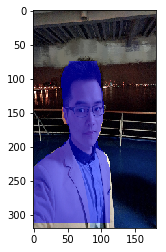

In [33]:
plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))

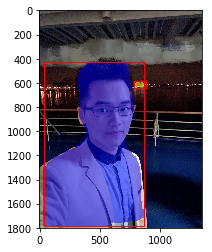

In [12]:
fig,ax = plt.subplots(1)
label1 = r['rois'][0]
label2 = r['rois'][1]
rect1 = patches.Rectangle((label1[1],label1[0]) ,label1[3] - label1[1],label1[2] - label1[0],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle((label2[1],label2[0]),label2[3] - label2[1],label2[2]- label2[0],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
plt.show()

data = {}
for k, v in r.items():
    data[k] = v.tolist()
json_string = json.dumps(data)